In [1]:
import os, sys
import scipy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn 
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.feature_extraction

%matplotlib inline


/usr/local/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
final_gdf = pickle.load(open("./data_out/source_of_truth.pkl","rb"))


final_gdf_cut = final_gdf[~final_gdf.food_sec_index.apply(lambda x: np.any([v is None for v in x]))].copy()
final_gdf_excl = final_gdf[final_gdf.food_sec_index.apply(lambda x: np.any([v is None for v in x]))].copy()


# Pre Processing

In [3]:
country_index_ts = np.array([list(v) for v in final_gdf_cut["country_index"].values])
rainfall_mm_ts = np.array([list(v) for v in final_gdf_cut["rainfall_mm"].values])
conflict_index_ts = np.array([list(v) for v in final_gdf_cut["conflict_index"].values])
food_sec_index_ts = np.array([list(v) for v in final_gdf_cut["food_sec_index"].values])

T_mem = 5
T = conflict_index_ts.shape[1]

X = []
y = []

for t in range(T_mem, T):
    x = np.concatenate([
        country_index_ts[:,t-T_mem:t+1],
        rainfall_mm_ts[:,t-T_mem:t+1],
        conflict_index_ts[:,t-T_mem:t+1],
    ], axis=1)
    
    yy = food_sec_index_ts[:,[t]]
    
    X.append(x)
    y.append(yy)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0).ravel()

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.7,random_state=0)

# Train

In [4]:
model = GradientBoostingRegressor(random_state=0,learning_rate = 0.5, n_estimators=100,max_depth=5)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=5, random_state=0)

# Test

on train:
R^2=0.9951912983857797
on test:
R^2=0.9662269901945564
MAE=0.029921104204385388
RMSQE=0.03796058613875602


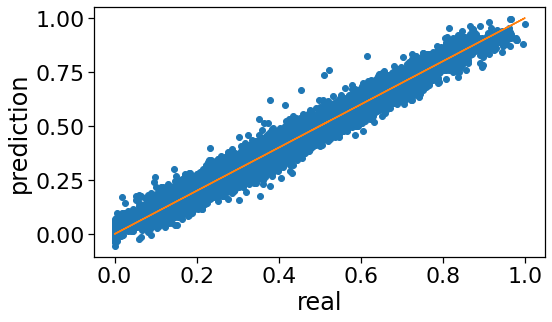

In [5]:
print("on train:")

y_train_pred = model.predict(X_train)
print("R^2={}".format(model.score(X_train, y_train)))


print("on test:")

y_test_pred = model.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_test_pred)
mae = sklearn.metrics.mean_absolute_error(y_test, y_test_pred)
rmsqe = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_test_pred))

print("R^2={}".format(r2))
print("MAE={}".format(mae))
print("RMSQE={}".format(rmsqe))


sns.set_context("notebook", font_scale=2)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(y_test, y_test_pred,'o')
ax.plot(y_test, y_test)

    
ax.set_xlabel("real")
ax.set_ylabel("prediction")
plt.tight_layout()
plt.savefig("figures/imp_model_precision_T_mem_{}.png".format(T_mem), dpi=300)

In [6]:
pickle.dump(model,open("models/imputation_model_T_mem_{}.pkl".format(T_mem),"wb"))

# Feature Importance

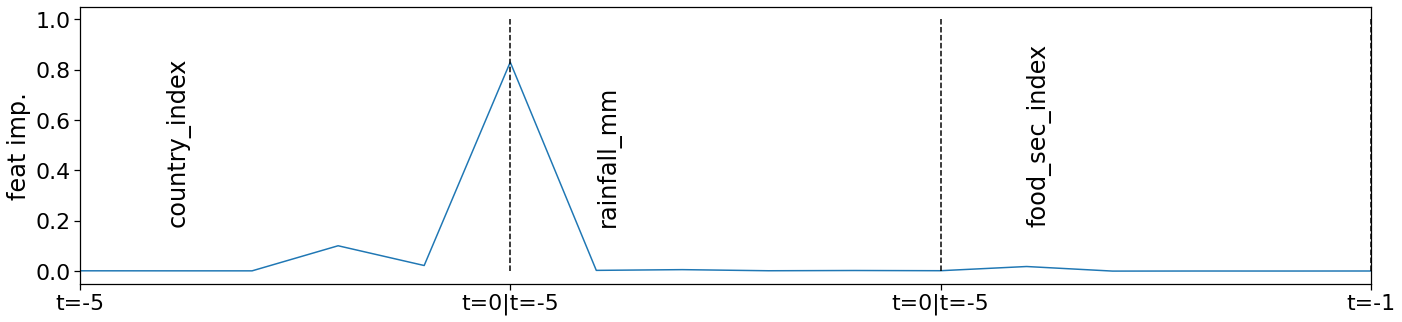

In [7]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(model.feature_importances_)
ax.set_ylabel("feat imp.")
ax.vlines(T_mem, 0,1, color="black", linestyles="dashed")
ax.vlines(2*T_mem, 0,1, color="black", linestyles="dashed")
ax.vlines(3*T_mem, 0,1, color="black", linestyles="dashed")

ax.text(T_mem-4,0.2,"country_index",rotation=90)
ax.text(2*T_mem-4,0.2,"rainfall_mm",rotation=90)
ax.text(3*T_mem-4,0.2,"food_sec_index",rotation=90)
ax.set_xlim(0,3*T_mem)
ax.set_xticks([0,T_mem,2*T_mem,3*T_mem]) 
ax.set_xticklabels(["t={}".format(-T_mem),"t={0}|t={1}".format(0,-T_mem),"t={0}|t={1}".format(0,-T_mem),"t={}".format(-1)]) 

plt.tight_layout()
plt.savefig("figures/imp_model_feat_imp_T_mem_{}.png".format(T_mem), dpi=300)